In this notebook, we solve an Allen-Cahn equation of the form
$$ \frac{\delta u}{\delta t} = d \frac{\delta^2 u}{\delta x^2} + 5\left( u - u^3 \right)$$

for $x \in [-1, 1]$ and $t \in [0, 1]$, with $d = 0.001$. We consider $t \in [0, 0.5]$ as the interpolation domain and $(0.5, 1]$ as the extrapolation domain. The initial condition is given by
$$ u(x, 0) = x^2 \cos (\pi x)$$

and the boundary condition is defined as
$$ u(-1, t) = u(1, t) = -1$$

### Preliminaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn 
import torch.nn.functional as F
from torch import optim
from torch.autograd import grad

from argparse import Namespace
from functools import reduce
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/229 Project'

Mounted at /content/drive
/content/drive/My Drive/229 Project


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DeepXDE

In [ ]:
# install deepxde
%pip install deepxde

# import packages

from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow.compat.v1")

import deepxde as dde
from deepxde.backend import tf

import numpy as np

import torch

import matplotlib.pyplot as plt
from scipy.io import loadmat

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# set up the problem

def gen_testdata():
    data = loadmat("Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    dt = dx = 0.01
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
d = 0.001

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - d * dy_xx - 5 * (y - y**3)

# define the boundary and initial conditions

def func(x):
    return (x[:, 0:1])**2 * np.cos(np.pi * x[:, 0:1])

bc = dde.icbc.DirichletBC(geomtime, lambda x: -1, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: (x[:, 0:1])**2 * np.cos(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Hard restraints on initial + boundary conditions   MIGHT WANT TO TEST THE EFFECT OF THIS ON EXTRAPOLATION BEHVAVIOR
def output_transform(x, y):
   return x[:, 0:1]**2 * tf.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

data = dde.data.TimePDE(geomtime, pde, [], num_domain=8000, num_boundary=400, num_initial=800)

In [ ]:
# set up the model

net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

model.compile("adam", lr=1e-4)

Compiling model...
Building feed-forward neural network...
'build' took 0.072229 s

'compile' took 9.937620 s



### Fourier Helper Functions

In [ ]:
def get_fft(y, sampling_rate):
  # Calculate the Fourier transform of f(x)
  fourier = np.fft.fft(y.squeeze())

  length = len(y)

  # Calculate the corresponding frequencies
  freq = np.fft.fftfreq(length, 1/sampling_rate)

  results = list(zip(freq, np.abs(fourier)))
  filtered = [(x, y) for (x, y) in results if x > 0]
  results = list(zip(*filtered))


  return results

In [ ]:
def compare_solutions(t, y_true, y_pred, domain_len):
  start = int(201 * t * 100)
  end = start + 201

  fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))

  ax0.plot(X[:, 0][start:end], y_true[start:end], "b-", label="Exact")
  ax0.plot(X[:, 0][start:end], y_pred[start:end], "r--", label="Prediction")
  ax0.legend()
  ax0.set_title(f"Comparing Solutions at Time {t}")
  ax0.set_xlabel("x")
  ax0.set_ylabel("u(x, t)")

  true_freq, true_fourier = get_fft(y_true[start:end], 201/domain_len)
  pred_freq, pred_fourier = get_fft(y_pred[start:end], 201/domain_len)
  ax1.plot(true_freq, true_fourier, "b-", label="Exact")
  ax1.plot(pred_freq, pred_fourier, "r--", label="Prediction")
  ax1.legend()
  ax1.set_title(f"Comparing Fourier Transforms of Solutions at Time {t}")
  ax1.set_xlabel("Frequency")
  ax1.set_ylabel("Amplitude")

  fourier_diff = abs(np.array(true_fourier) - np.array(pred_fourier))
  ax2.plot(true_freq, fourier_diff, "b-")
  ax2.set_title(f"Difference in Fourier Transforms of Solutions at Time {t}")
  ax2.set_xlabel("Frequency")
  ax2.set_ylabel("Absolute Difference in Amplitude")
  
  plt.show()

In [ ]:
import pandas as pd
from matplotlib.colors import LogNorm, Normalize

def plot_spectral_dynamics(all_preds, y_true, t, domain_len):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    start = int(201 * t * 100)
    end = start + 201
    
    true_freq, true_fourier = get_fft(y_true[start:end], 201/domain_len)

    pct_dict = {"iter": [], "freq": [], "value": []}
    error_dict = {"iter": [], "freq": [], "value": []}
    # Compute spectra for all frames
    for iter, pred in all_preds.items(): 
        if iter % 1000 == 0 or iter == 500:
          pred_freq, pred_fourier = get_fft(pred[start:end], 201/domain_len)
          pct_diff = abs(np.array(pred_fourier) - np.array(true_fourier))/np.array(true_fourier) * 100
          abs_diff = abs(np.array(pred_fourier) - np.array(true_fourier))

          for idx, freq in enumerate(pred_freq):
            pct_dict["iter"].append(iter)
            pct_dict['freq'].append(freq)
            pct_dict['value'].append(pct_diff[idx])

            error_dict["iter"].append(iter)
            error_dict['freq'].append(freq)
            error_dict['value'].append(abs_diff[idx])


    pct_diffs = pd.DataFrame(data = pct_dict)
    pct_diffs = pct_diffs.round(3)
    pct_diffs = pct_diffs.pivot("iter", "freq", "value")
    sns.heatmap(pct_diffs, yticklabels=20, xticklabels=10, vmin=0., vmax=100, cbar_kws={'label': 'Percentage Error in Amplitude'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Frequency")
    ax0.set_ylabel("Training Iteration")
    ax0.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")


    abs_diffs = pd.DataFrame(data = error_dict)
    abs_diffs = abs_diffs.round(3)
    abs_diffs = abs_diffs.pivot("iter", "freq", "value")
    sns.heatmap(abs_diffs, yticklabels=20, xticklabels=10, vmin=0., vmax=max(error_dict['value']), cbar_kws={'label': 'Absolute Error in Amplitude'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Training Iteration")
    ax1.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")

    plt.show()

In [ ]:
def plot_l2_errors(preds, y_true, iteration, domain_len):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    freq_dict = {"time": [], "freq": [], "value": []}
    x_dict = {"time": [], "x": [], "value": []}

    for t in np.linspace(0, 0.99, 100):
      start = int(201 * t * 100)
      end = start + 201
      xs = X[:, 0][start:end]
      true_freq, true_fourier = get_fft(y_true[start:end], 201/domain_len)
      pred_freq, pred_fourier = get_fft(preds[start:end], 201/domain_len)
      freq_diff = abs(np.array(pred_fourier) - np.array(true_fourier))

      true_sol = y_true[start:end]
      pred_sol = preds[start:end]
      abs_diff = abs(np.array(pred_sol) - np.array(true_sol))[0]

      for idx, freq in enumerate(pred_freq):
        freq_dict["time"].append(t)
        freq_dict['freq'].append(freq)
        freq_dict['value'].append((freq_diff[idx] ** 2))

      for idx, _ in enumerate(pred_sol):
        if idx != 200:
          x_dict["time"].append(t)
          x_dict['x'].append(xs[idx])
          x_dict['value'].append((abs_diff[idx] ** 2))

    freq_errors = pd.DataFrame(data = freq_dict)
    freq_errors = freq_errors.round(3)
    freq_errors = freq_errors.pivot("time", "freq", "value")
    sns.heatmap(freq_errors, yticklabels=3, xticklabels=10, vmin=0, norm=LogNorm(), cbar_kws={'label': 'L2 Error of Prediction'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Frequency")
    ax0.set_ylabel("Time")
    ax0.set_title(f"Decomposing L2 Error of Predicted Solution at Iteration {iteration}")

    l2_errors = pd.DataFrame(data = x_dict)
    l2_errors = l2_errors.round(3)
    l2_errors = l2_errors.pivot("time", "x", "value")
    sns.heatmap(l2_errors, yticklabels=3, xticklabels=10, vmin=0, norm=LogNorm(), cbar_kws={'label': 'L2 Error of Prediction'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    ax1.set_title(f"Decomposing L2 Error of Predicted Solution at Iteration {iteration}")

    plt.show()

### Train Model

In [ ]:
# import pickle

# # train the model
# model_preds = {}

# for iter in range(500):
#   losshistory, train_state = model.train(iterations=1000)
#   X, y_true = gen_testdata()
#   y_pred = model.predict(X)
#   cur_iter = (iter + 1) * 1000
#   model_preds[cur_iter] = y_pred

# with open('model_preds_allen_cahn.pkl', 'wb') as f:
#   pickle.dump(model_preds, f)

Streaming output truncated to the last 5000 lines.

Best model at step 116000:
  train loss: 2.81e-06
  test loss: 2.81e-06
  test metric: []

'train' took 3.259976 s

Training model...

Step      Train loss    Test loss     Test metric
116000    [2.81e-06]    [2.81e-06]    []  
117000    [3.40e-06]    [3.40e-06]    []  

Best model at step 116000:
  train loss: 2.81e-06
  test loss: 2.81e-06
  test metric: []

'train' took 3.694445 s

Training model...

Step      Train loss    Test loss     Test metric
117000    [3.40e-06]    [3.40e-06]    []  
118000    [2.79e-06]    [2.79e-06]    []  

Best model at step 118000:
  train loss: 2.79e-06
  test loss: 2.79e-06
  test metric: []

'train' took 3.283454 s

Training model...

Step      Train loss    Test loss     Test metric
118000    [2.79e-06]    [2.79e-06]    []  
119000    [3.20e-06]    [3.20e-06]    []  

Best model at step 118000:
  train loss: 2.79e-06
  test loss: 2.79e-06
  test metric: []

'train' took 3.283306 s

Training model..

### Visualizations

In [ ]:
X, y_true = gen_testdata()

with open('model_preds_allen_cahn.pkl', 'rb') as f:
    all_preds = pickle.load(f)

<ipython-input-47-2506112306e6>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-47-2506112306e6>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


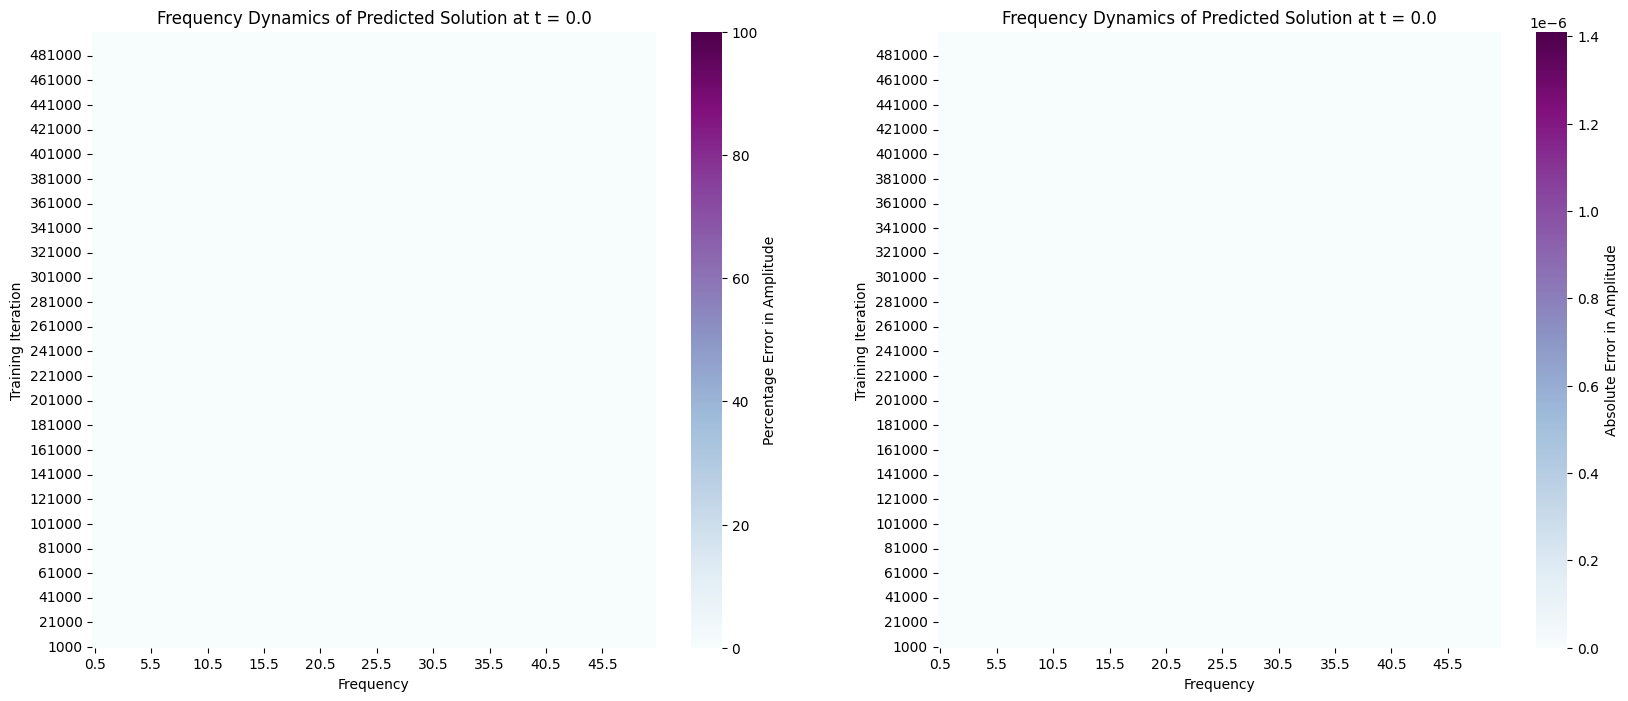

<ipython-input-47-2506112306e6>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-47-2506112306e6>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


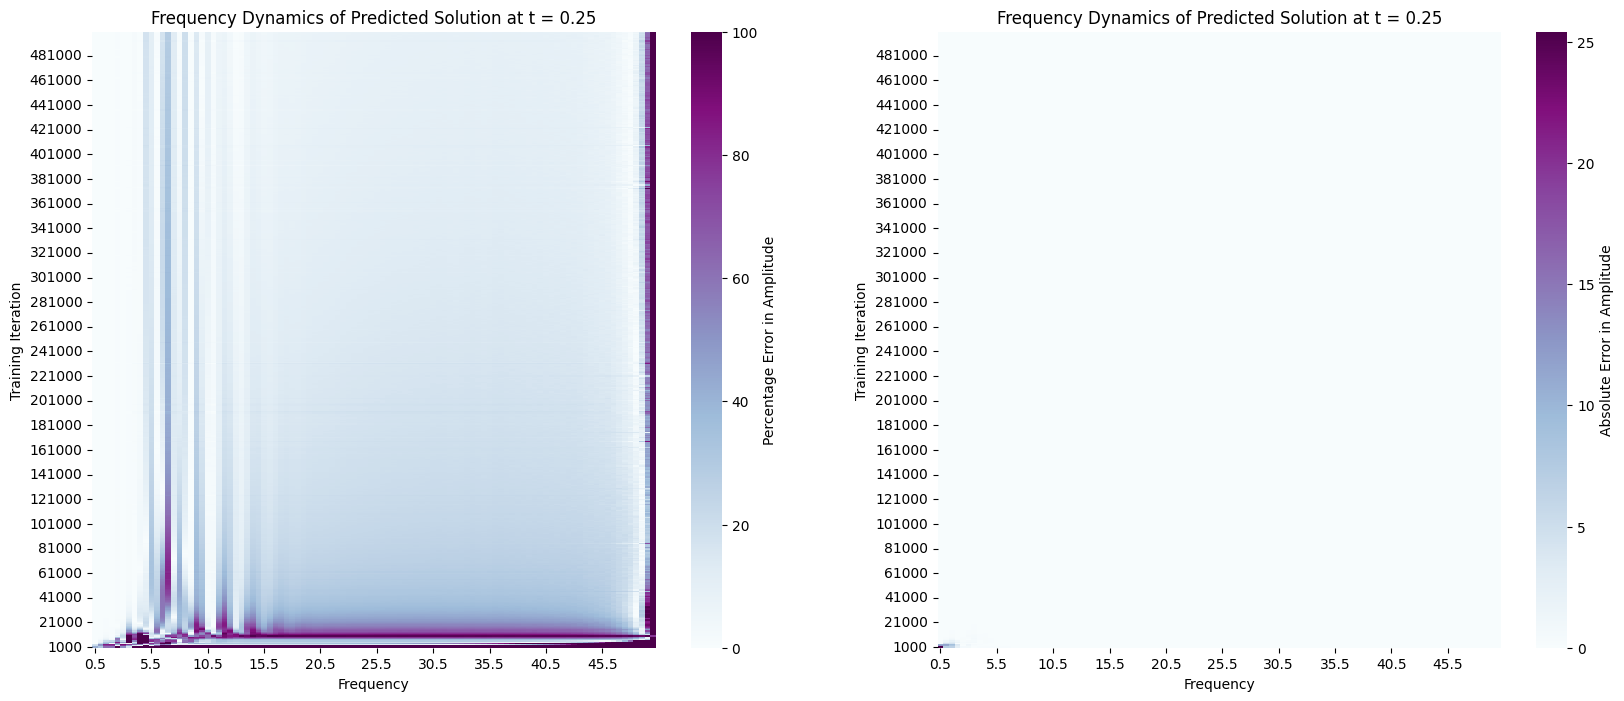

<ipython-input-47-2506112306e6>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-47-2506112306e6>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


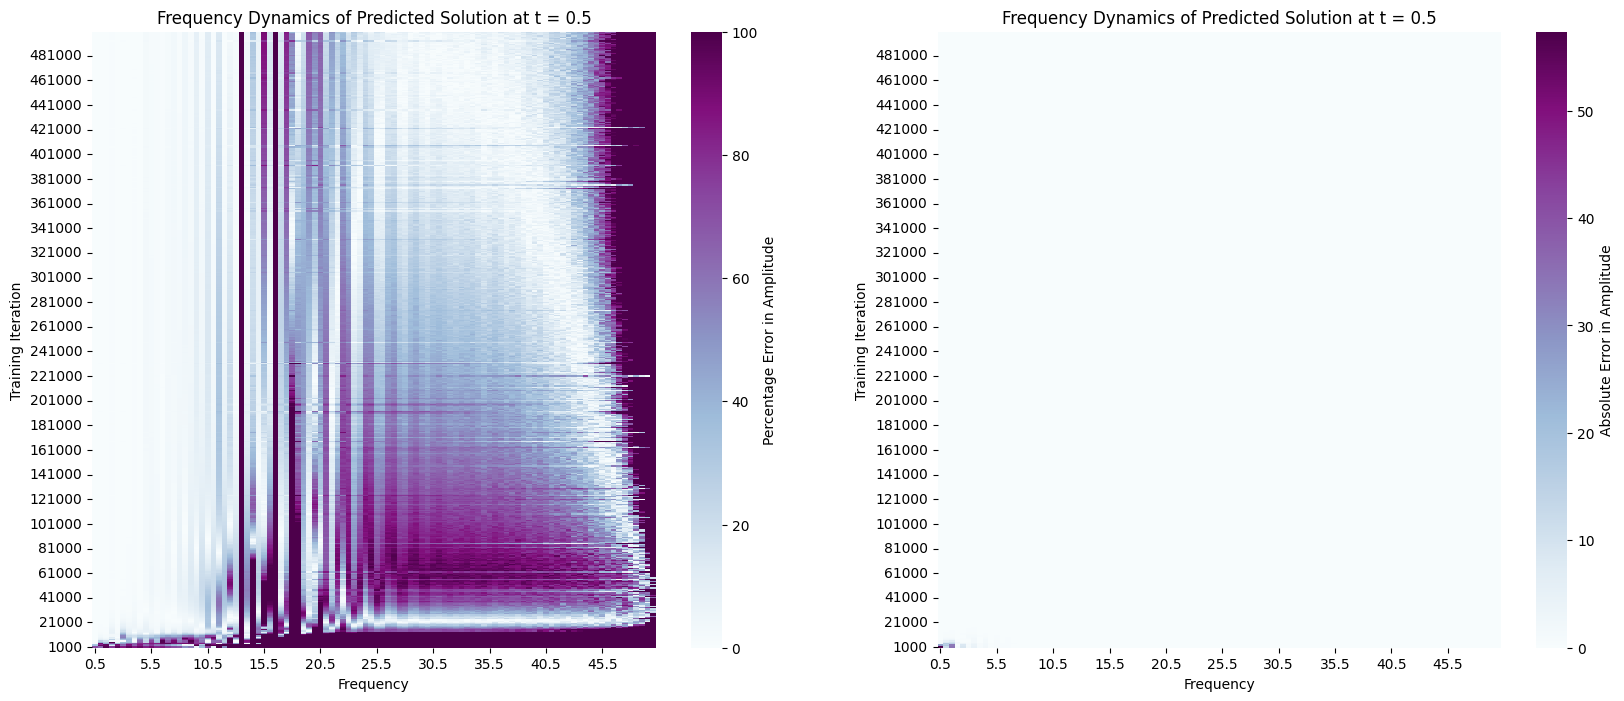

<ipython-input-47-2506112306e6>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-47-2506112306e6>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


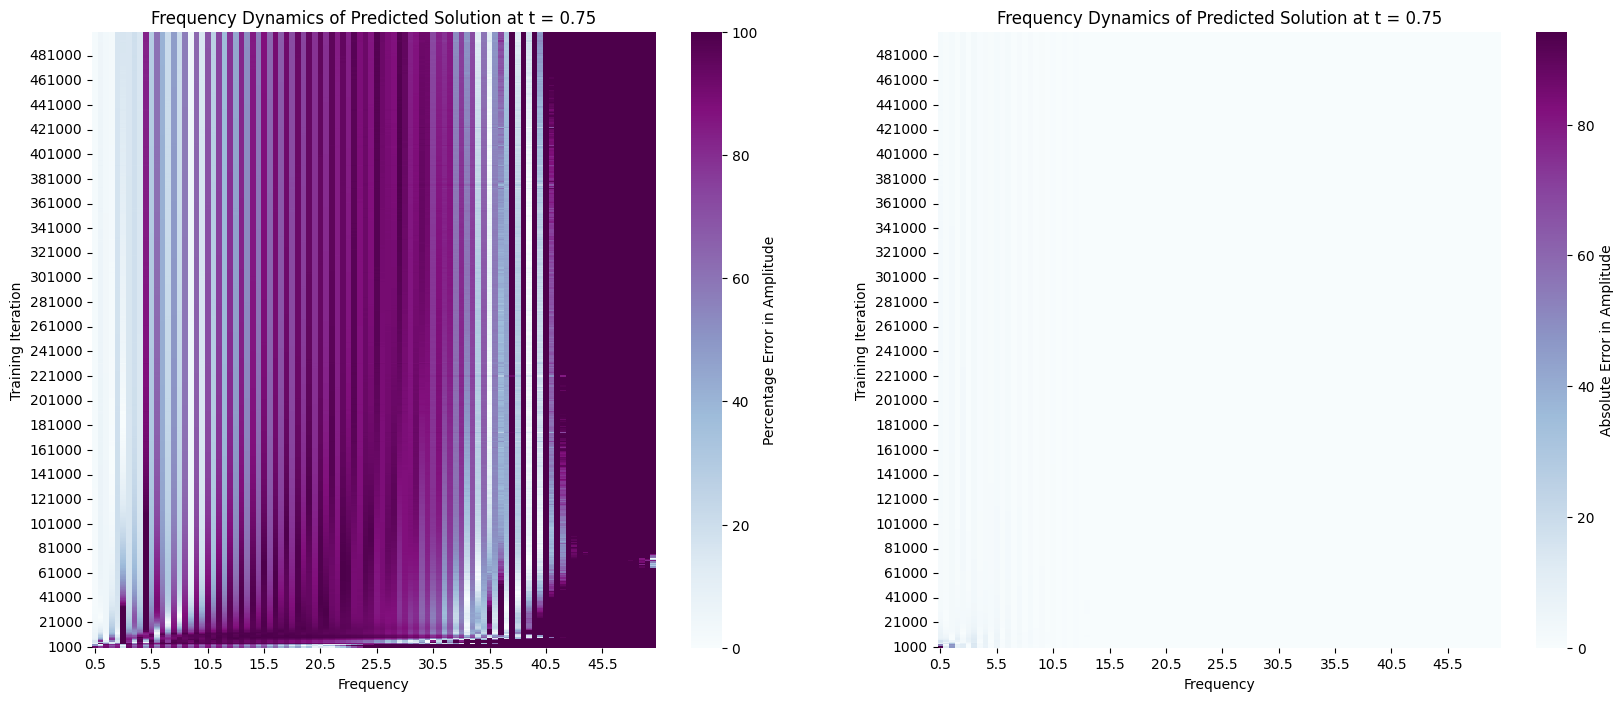

<ipython-input-47-2506112306e6>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-47-2506112306e6>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


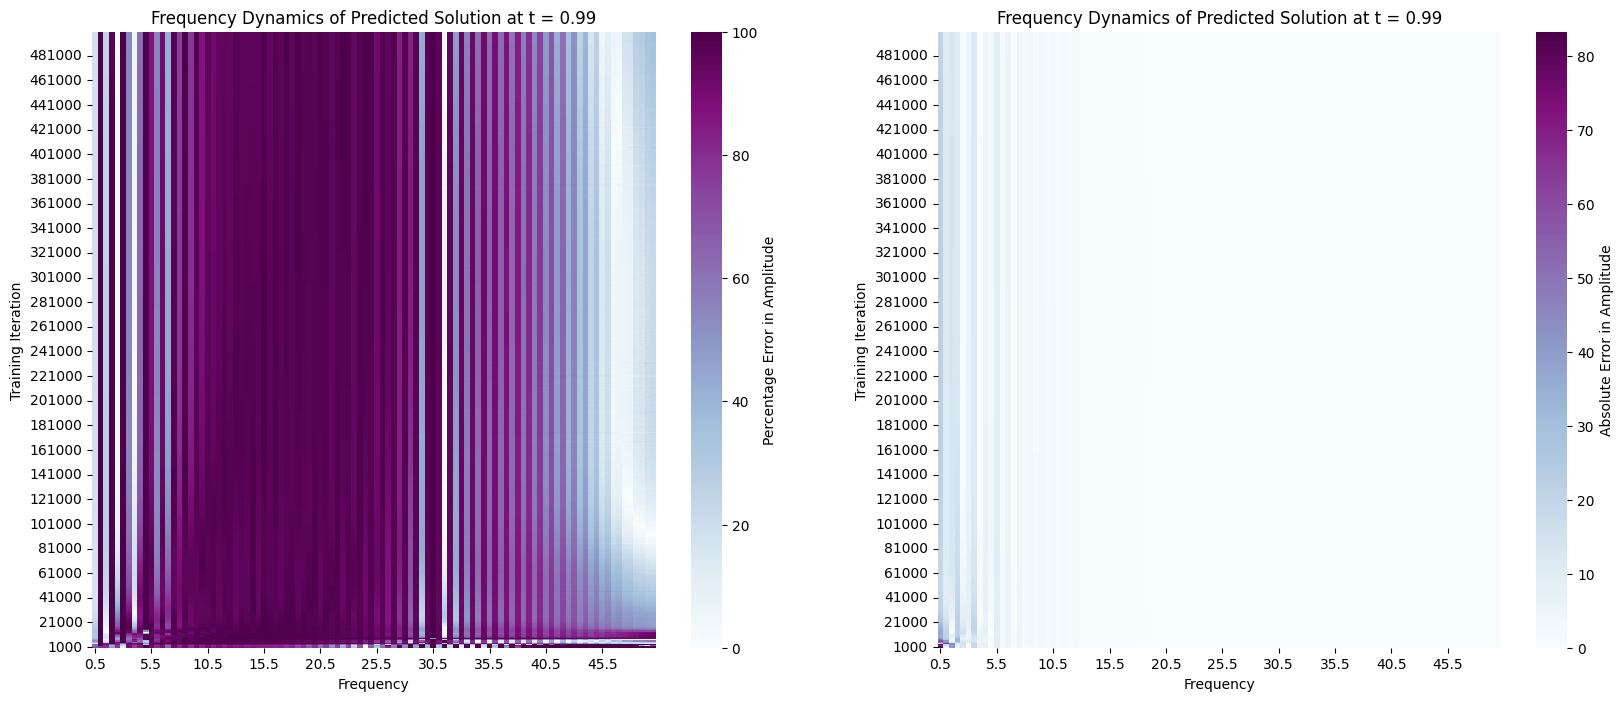

In [ ]:
plot_spectral_dynamics(all_preds, y_true, 0.00, domain_len=2)
plot_spectral_dynamics(all_preds, y_true, 0.25, domain_len=2)
plot_spectral_dynamics(all_preds, y_true, 0.50, domain_len=2)
plot_spectral_dynamics(all_preds, y_true, 0.75, domain_len=2)
plot_spectral_dynamics(all_preds, y_true, 0.99, domain_len=2)

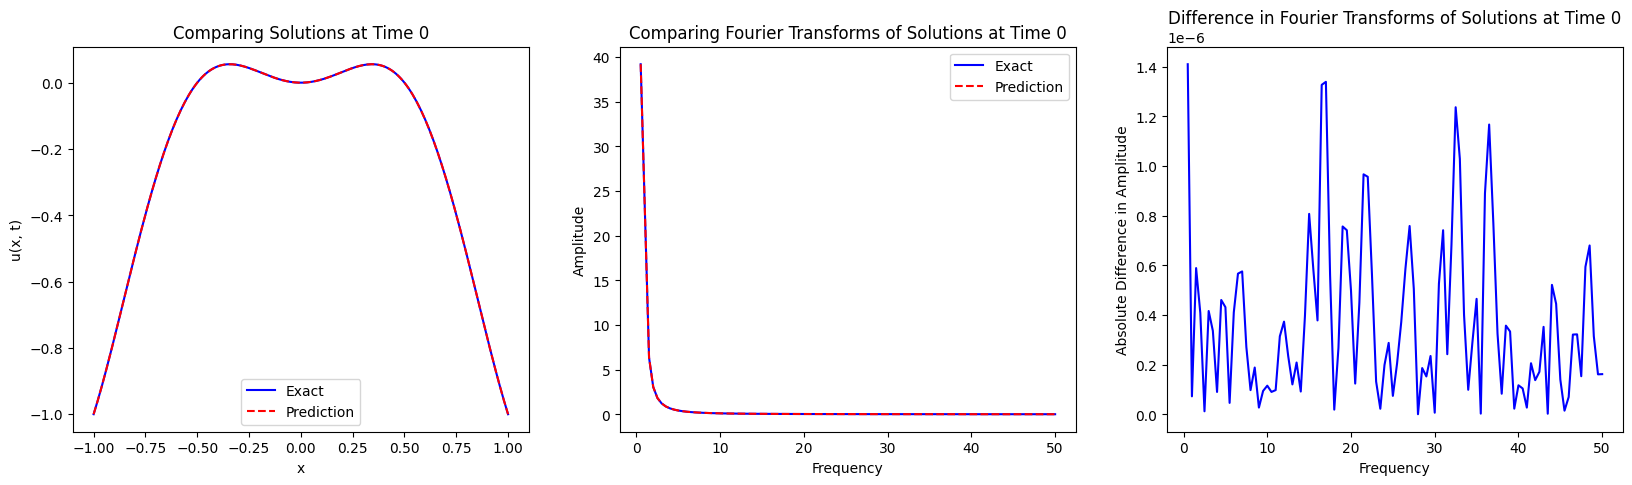

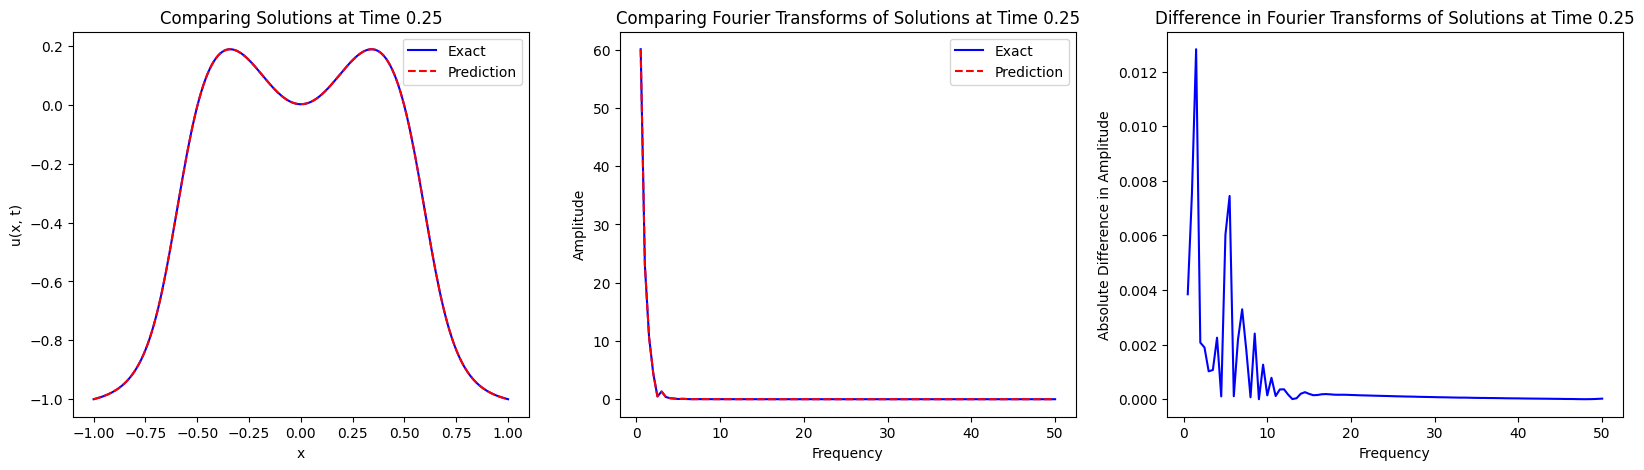

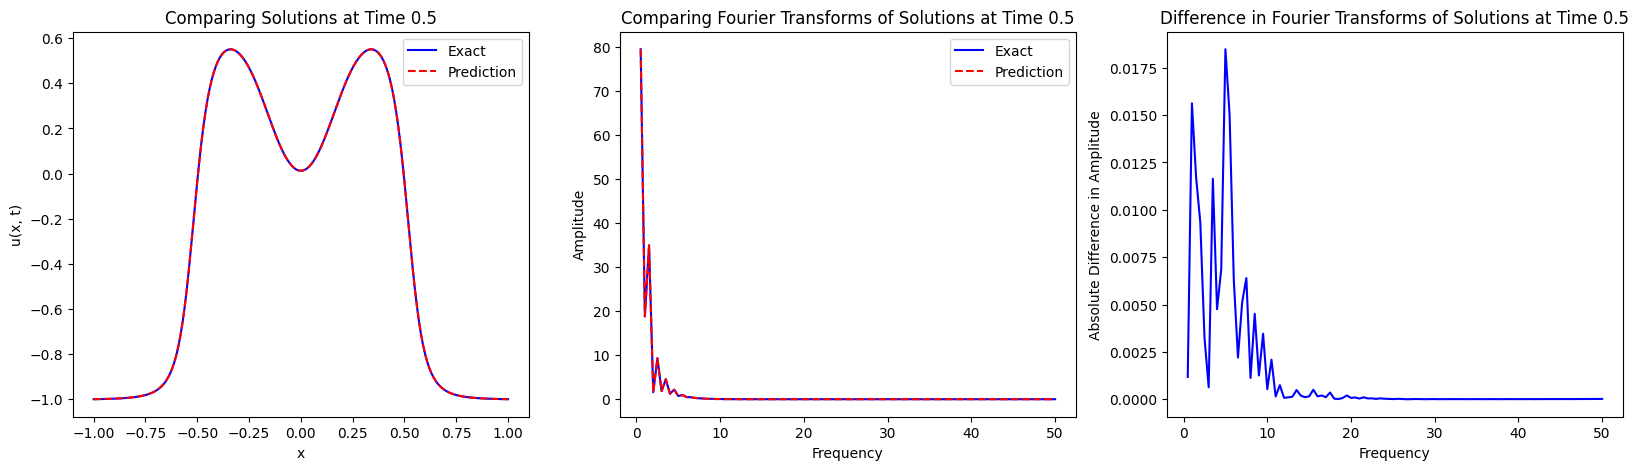

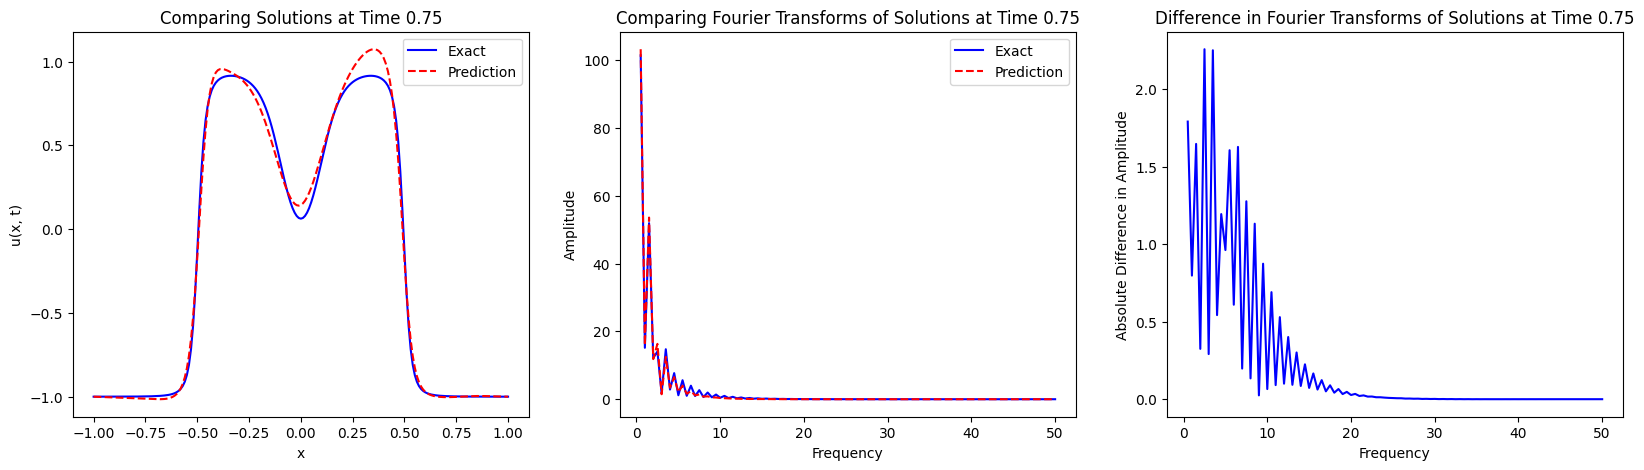

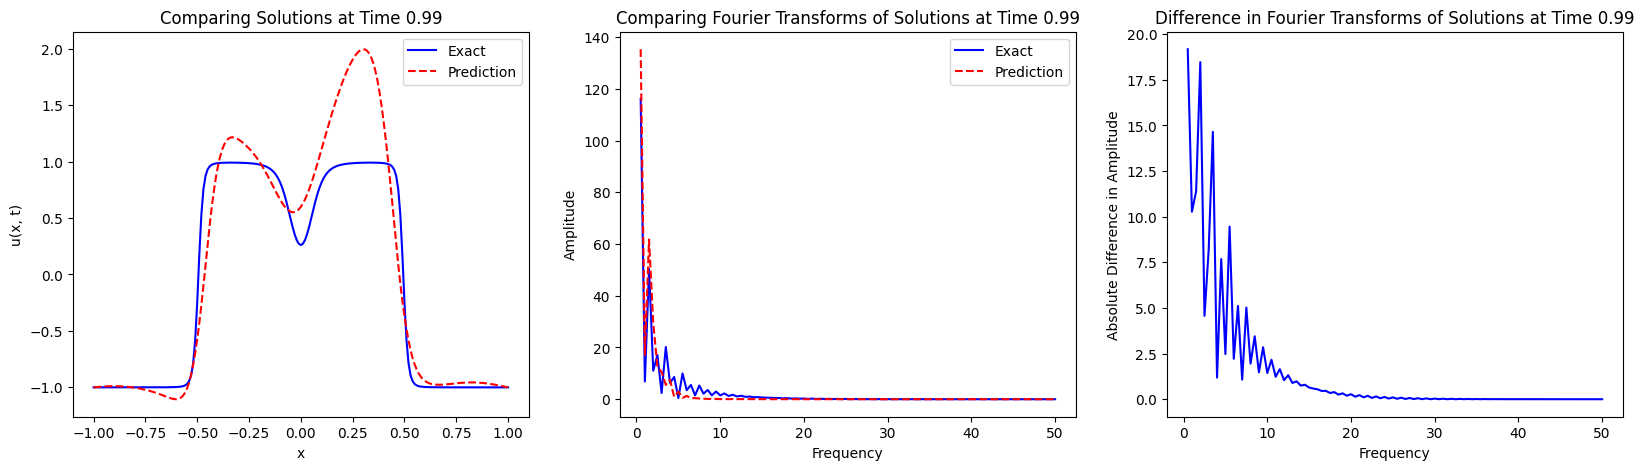

In [ ]:
compare_solutions(0, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.25, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.5, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.75, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.99, y_true, all_preds[50000], domain_len=2)

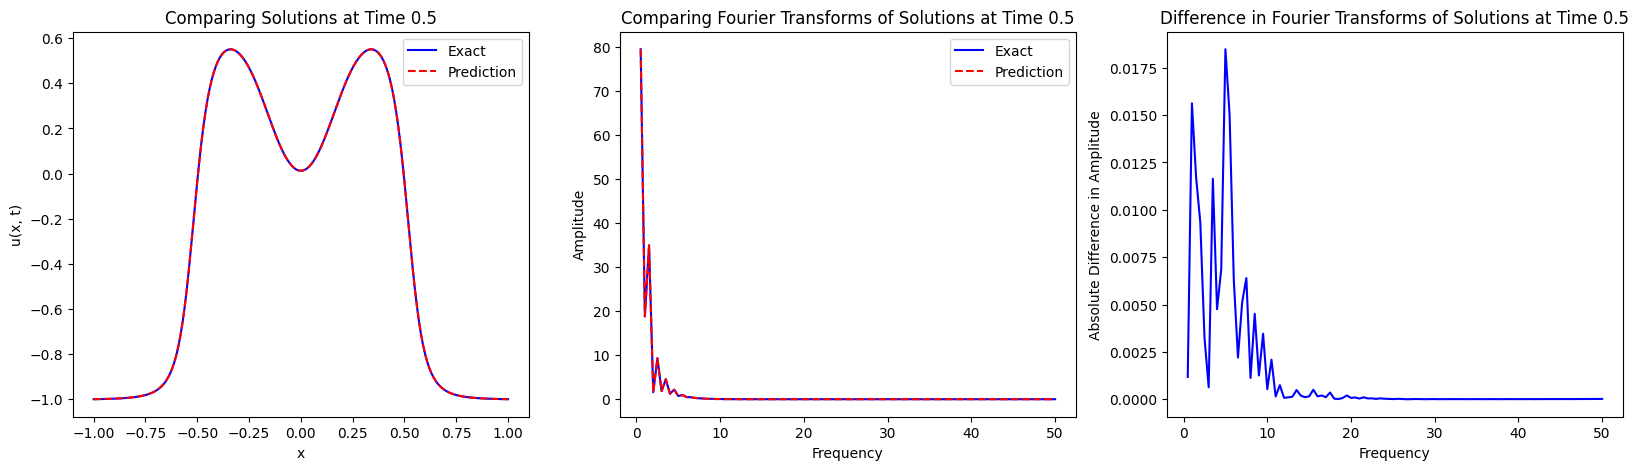

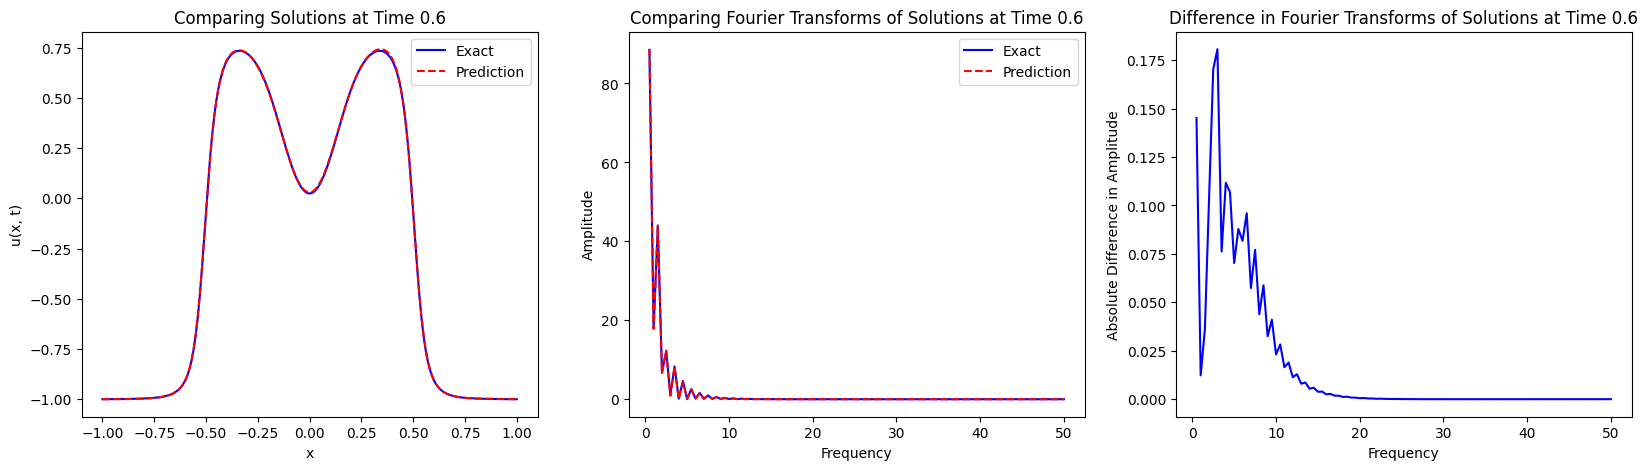

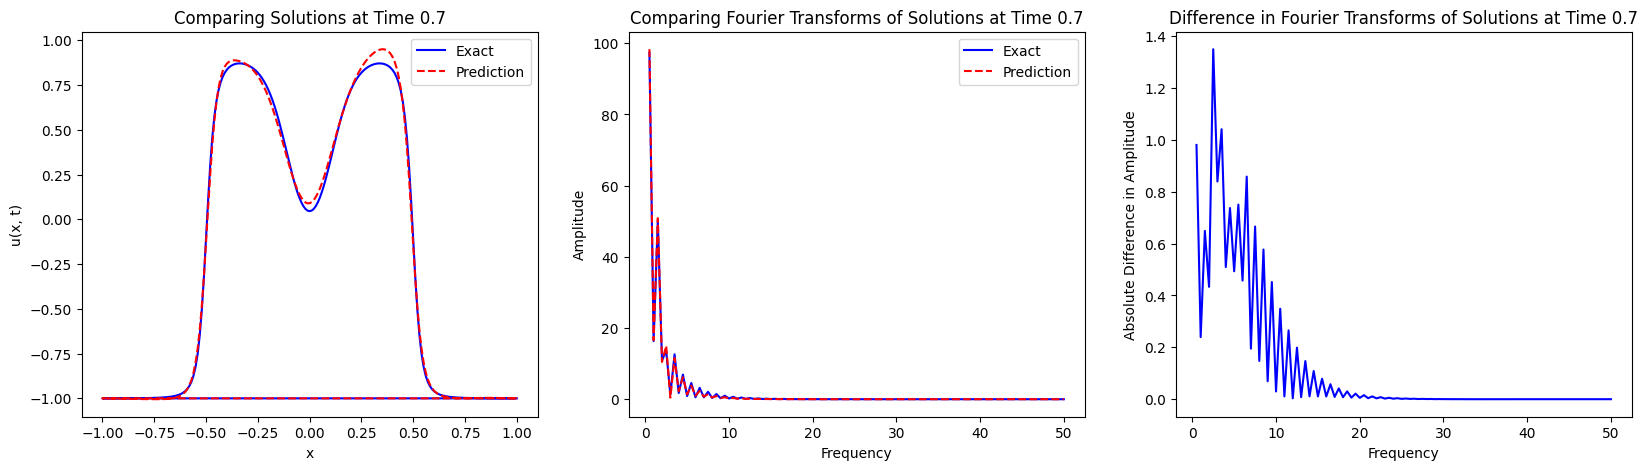

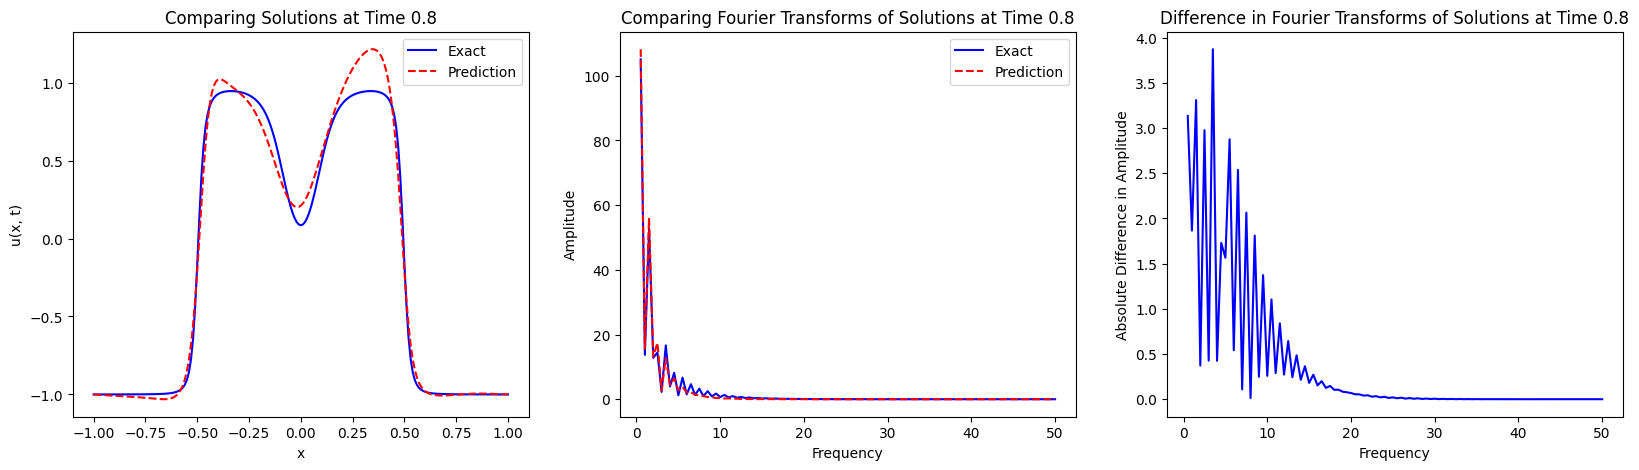

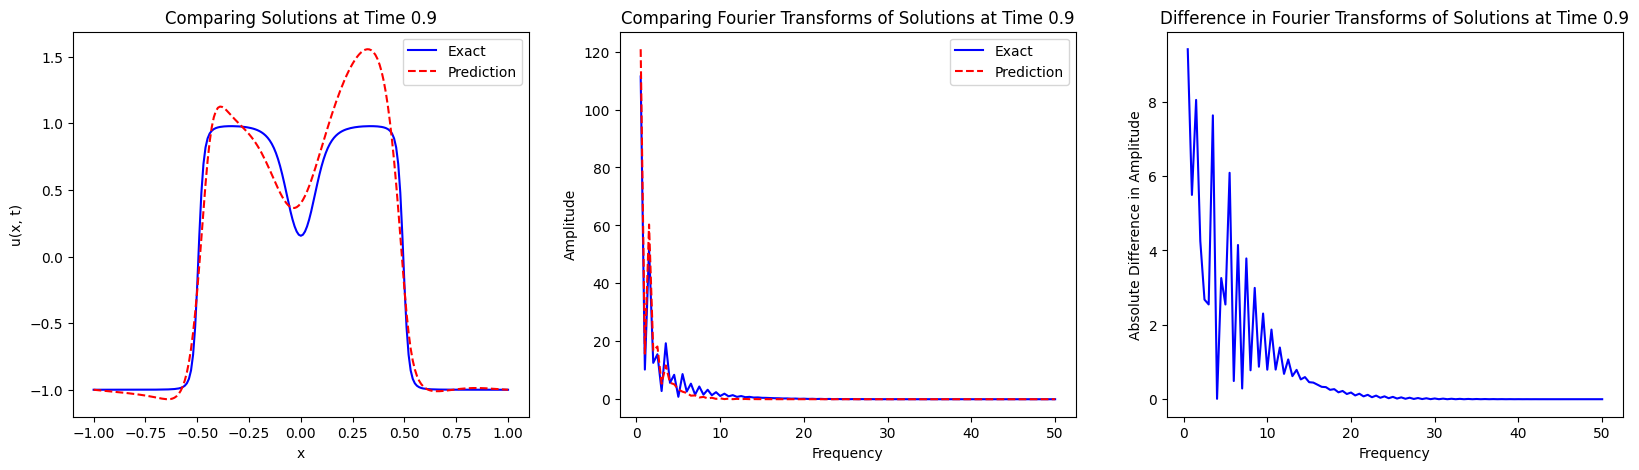

In [ ]:
compare_solutions(0.5, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.6, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.7, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.8, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.9, y_true, all_preds[500000], domain_len=2)

<ipython-input-48-91b1ddd32b63>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-48-91b1ddd32b63>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


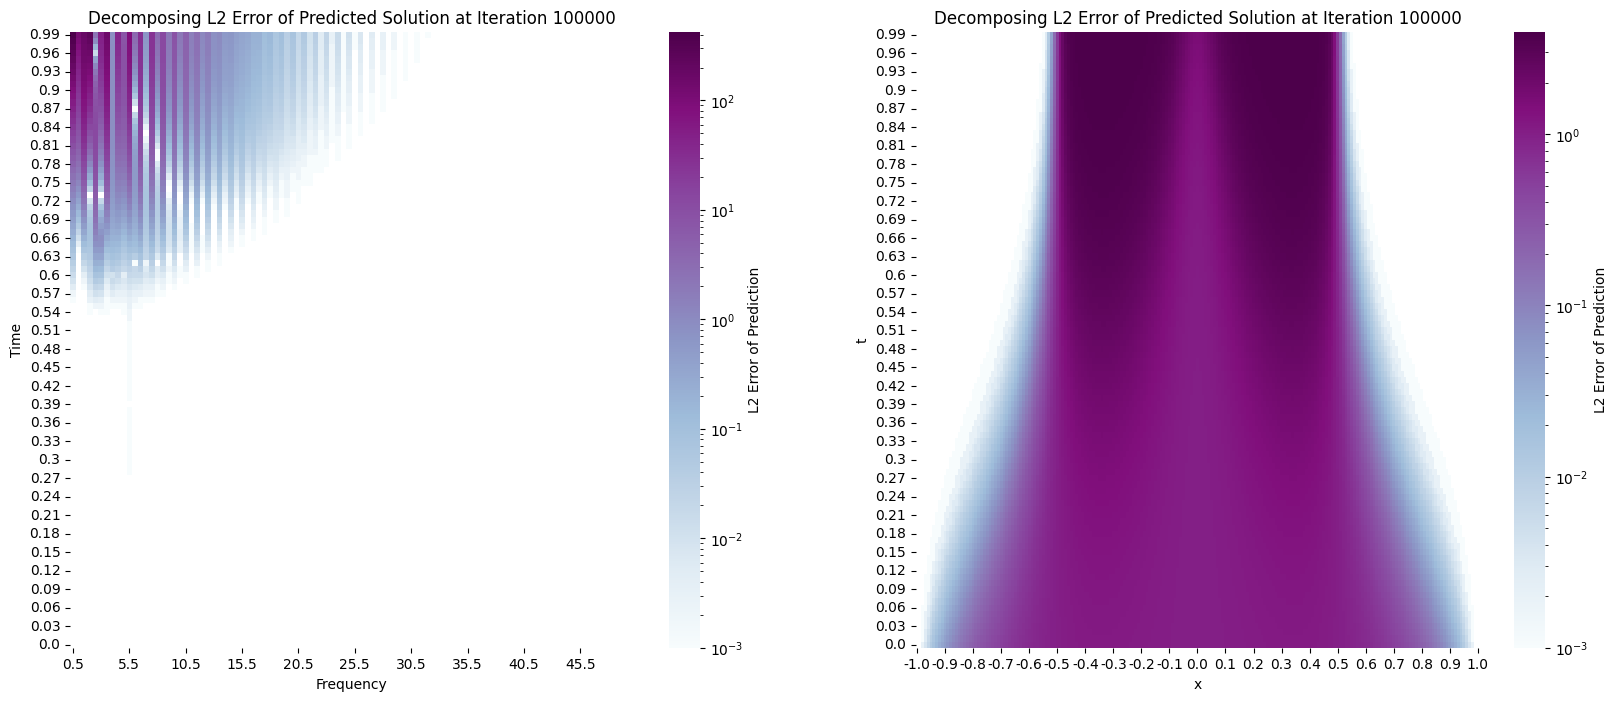

<ipython-input-48-91b1ddd32b63>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-48-91b1ddd32b63>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


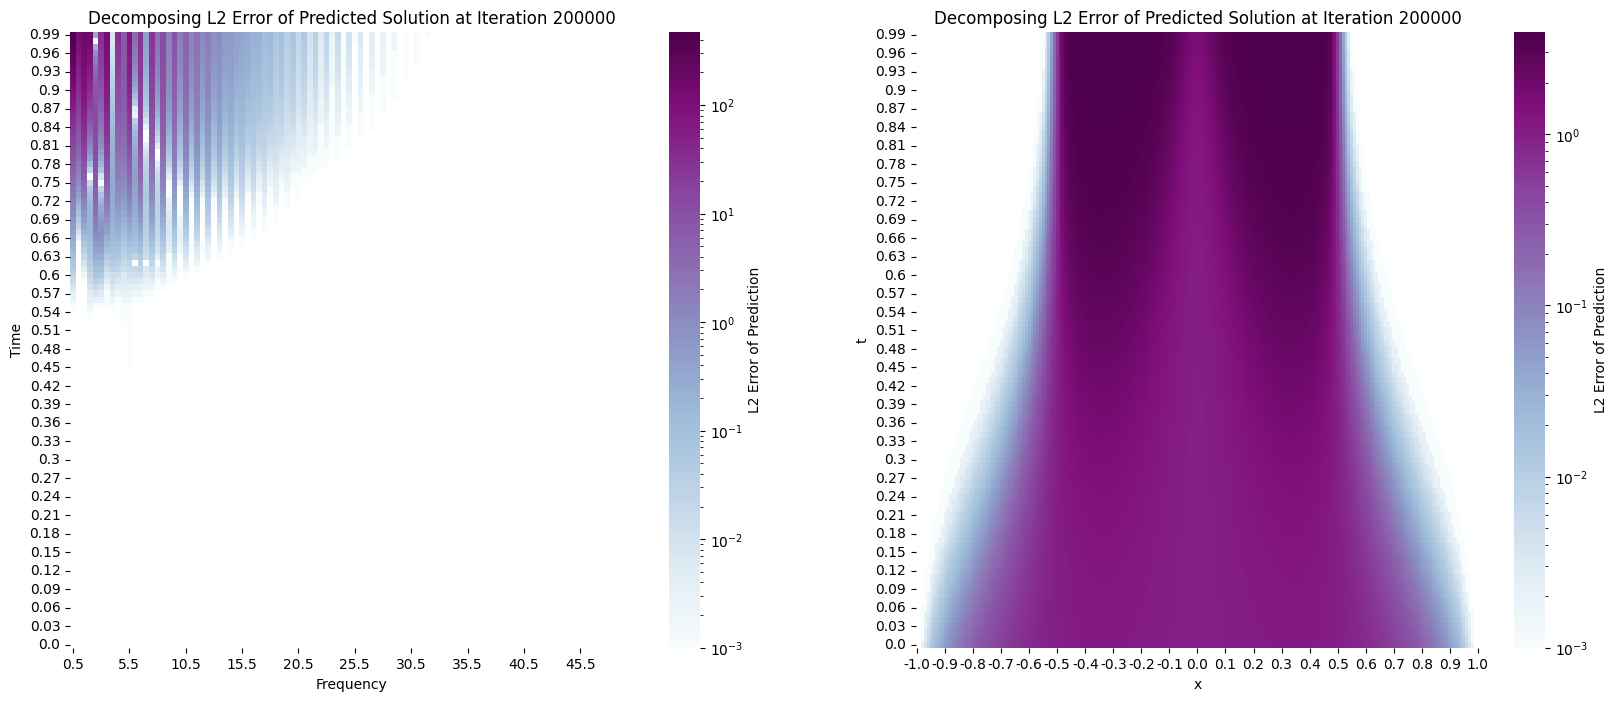

<ipython-input-48-91b1ddd32b63>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-48-91b1ddd32b63>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


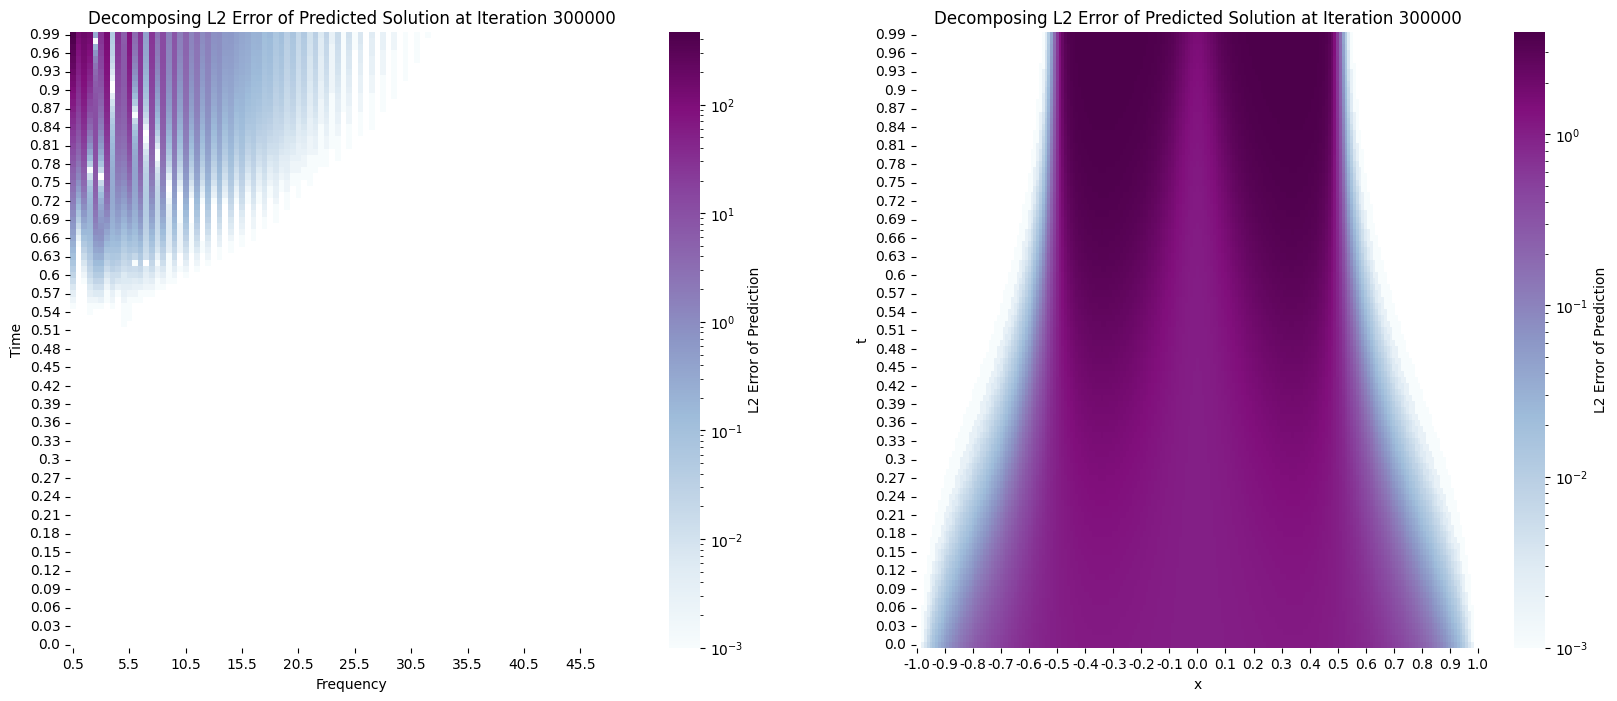

<ipython-input-48-91b1ddd32b63>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-48-91b1ddd32b63>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


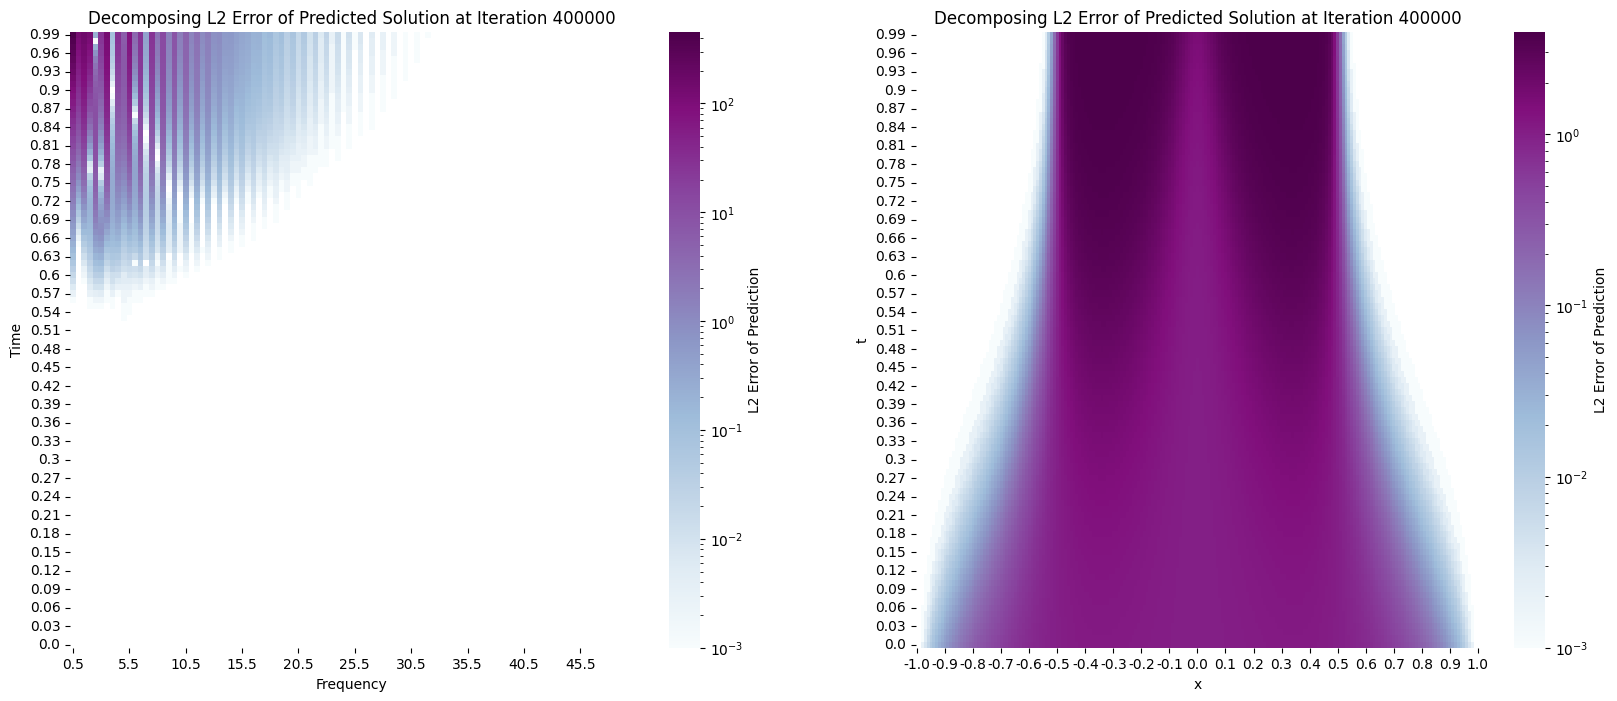

<ipython-input-48-91b1ddd32b63>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-48-91b1ddd32b63>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


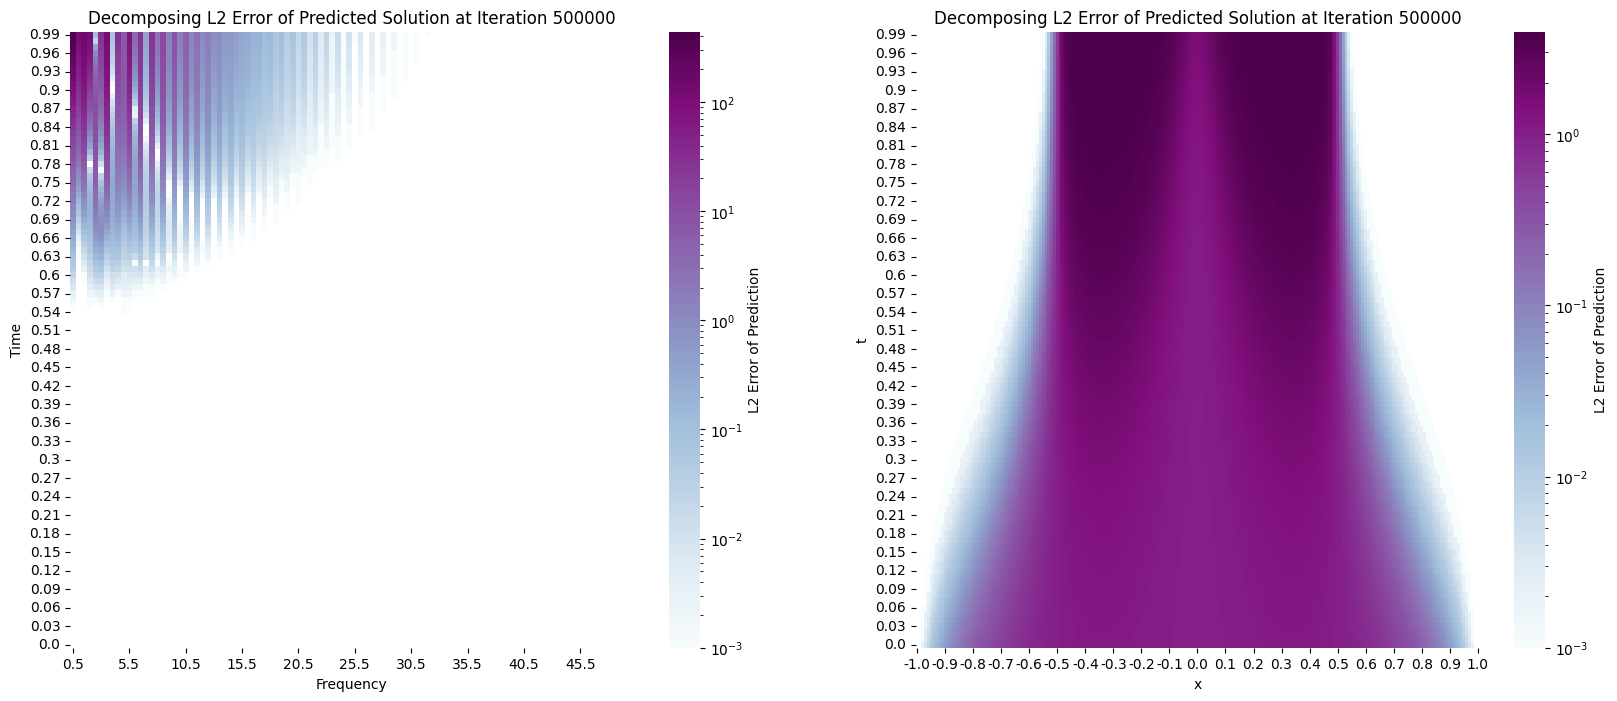

In [ ]:
plot_l2_errors(all_preds[100000], y_true, 100000, domain_len=2)
plot_l2_errors(all_preds[200000], y_true, 200000, domain_len=2)
plot_l2_errors(all_preds[300000], y_true, 300000, domain_len=2)
plot_l2_errors(all_preds[400000], y_true, 400000, domain_len=2)
plot_l2_errors(all_preds[500000], y_true, 500000, domain_len=2)